<a href="https://colab.research.google.com/github/jiahao303/music-classifier/blob/main/Music_Classifier_Nov_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Classifier Step 3: Tensorflow Datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

First, we get an inspection on one of the lyrics. We found that most of the neutral words such as pronouns (i.e. we, you, I) and auxiliaries are omitted since they have no use for the sentiment identifying.

In [2]:

url = 'https://raw.githubusercontent.com/jiahao303/music-classifier/main/tcc_ceds_music.csv'

df = pd.read_csv(url)

In [3]:

df = df.drop(["Unnamed: 0", "release_date"], axis =1)
df.at[5,"lyrics"]

'convoy light dead ahead merchantmen trump diesels hammer oily kill grind knuckle white eye alight slam hatch deadly night cunning chicken lair hound hell devil care run silent run deep final prayer warriors secret sleep merchantman nightmare silent death lie wait run silent run deep sink final sleep chill hearts fight open ocean wonder lethal silver fish boat shiver cast millions play killer victim fool obey order rehearse lifeboat shatter hull tear black smell burn jones eye watch crosswire tube ready medal chest weeks dead like rest run silent run deep final prayer warriors secret sleep merchantman nightmare'

Get the dataframe resorted, only keep the lyrics column and the sentiment/topic column.

In [4]:
sentiment = df[["lyrics", "topic"]]
sentiment

,lyrics,topic
0,hold time feel break feel untrue convince spea...,sadness
1,believe drop rain fall grow believe darkest ni...,world/life
2,sweetheart send letter goodbye secret feel bet...,music
3,kiss lips want stroll charm mambo chacha merin...,romantic
4,till darling till matter know till dream live ...,romantic
...,...,...
28367,cause fuck leave scar tick tock clock come kno...,obscene
28368,minks things chain ring braclets yap fame come...,obscene
28369,get ban get ban stick crack relax plan attack ...,obscene
28370,check check yeah yeah hear thing call switch g...,obscene


Our task will be to teach an algorithm to classify lyrics by predicting the topic based on the text of the lyrics.

In [5]:
sentiment.groupby("topic").size()

topic
feelings       612
music         2303
night/time    1825
obscene       4882
romantic      1524
sadness       6096
violence      5710
world/life    5420
dtype: int64

Encode the "topic" column values with integers.

In [6]:
le = LabelEncoder()
sentiment["topic"] = le.fit_transform(sentiment["topic"])
sentiment.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lyrics,topic
0,hold time feel break feel untrue convince spea...,5
1,believe drop rain fall grow believe darkest ni...,7
2,sweetheart send letter goodbye secret feel bet...,1
3,kiss lips want stroll charm mambo chacha merin...,4
4,till darling till matter know till dream live ...,4


Inspect which integers correspond to which classes using the classes_ attribute of the encoder.

In [7]:
le.classes_

array(['feelings', 'music', 'night/time', 'obscene', 'romantic',
       'sadness', 'violence', 'world/life'], dtype=object)

In [8]:
data = tf.data.Dataset.from_tensor_slices((sentiment["topic"],sentiment["lyrics"]))

Iterate over the data values.

In [9]:
for lyrics,topic in data.take(5):
    print(lyrics)
    print(topic)
    print("")

tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(b'hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little turn dust play house ruin run leave save like chase train late late tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little run leave save like chase train know late late play break string feel heart want feel tell real truth hurt lie worse anymore little know little hold time feel', shape=(), dtype=string)

tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(b'believe drop rain fall grow believe darkest night candle glow believe go astray come believe believe believe smallest prayer hear believe great hear word time hear bear baby touch leaf believe believe believe lord heaven guide sin hide believe calvary die pierce believe death rise meet heaven loud amen know believe', shape=(), dtype=string)

tf.Tensor(

We have created a special TensorFlow Dataset.
Now, we will split it into training, validation, and testing sets.

In [10]:
data = data.shuffle(buffer_size = len(data))

In [11]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [12]:
len(train), len(val), len(test)

(19860, 2837, 5675)

In [13]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [14]:
max_tokens = 2000
# each headline will be a vector of length 40
sequence_length = 40

vectorize_layer = TextVectorization(
    max_tokens = max_tokens,
    standardize=standardization,
    output_mode='int',
    output_sequence_length=sequence_length)

We need to adapt the vectorization layer to the lyrics. In the adaptation process, the vectorization layer learns what words are common in the lyrics.

In [15]:
lyrics = train.map(lambda x, y: y)
vectorize_layer.adapt(lyrics)

we define a helper function that operates on our Datasets. Note that our Dataset consists of a bunch of tuples of the form (topic, lyrics) for each data observation. Our helper function therefore accepts and returns two variables.

In [16]:
def vectorize_headline(label, text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec   = val.map(vectorize_headline)
test_vec  = test.map(vectorize_headline)

Let's take a look at a vectorized piece of text.

In [17]:
list(train_vec.take(2))

[(<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[  17,   17,   17,   82,   31,    4,   31,    4,   31,  216,  392,
           856,  357,   46, 1317,  327,   75,   40,   20,  596,  141,   75,
            71,   31,  216,    9,  230,    5,   49,    5,    5,   22,   63,
           472,   31,    0,    0,    0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>),
 (<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[1633,    1, 1633,    1,    1,    1,   12,    1, 1633,    1,    1,
            56,    8,   56,   92,    1,  114,   11,  114,  114,  114, 1103,
            56,   96,   96,  321,   24,  160,   99,   99,   99,    1,   56,
           134,   96,   16,   11,    1, 1379,  117]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

## Modeling

In [18]:
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 8, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(8)]
)

In [19]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [20]:
history = model.fit(train_vec, epochs = 10, validation_data = val_vec)

Epoch 1/10
19860/19860 [==============================] - 104s 5ms/step - loss: 1.2120 - accuracy: 0.6213 - val_loss: 0.6995 - val_accuracy: 0.8075
Epoch 2/10
19860/19860 [==============================] - 101s 5ms/step - loss: 0.6583 - accuracy: 0.7920 - val_loss: 0.4573 - val_accuracy: 0.8629
Epoch 3/10
19860/19860 [==============================] - 102s 5ms/step - loss: 0.5401 - accuracy: 0.8262 - val_loss: 0.3731 - val_accuracy: 0.8900
Epoch 4/10
19860/19860 [==============================] - 105s 5ms/step - loss: 0.4873 - accuracy: 0.8414 - val_loss: 0.3411 - val_accuracy: 0.8943
Epoch 5/10
19860/19860 [==============================] - 103s 5ms/step - loss: 0.4720 - accuracy: 0.8451 - val_loss: 0.2991 - val_accuracy: 0.9073
Epoch 6/10
19860/19860 [==============================] - 103s 5ms/step - loss: 0.4477 - accuracy: 0.8482 - val_loss: 0.2850 - val_accuracy: 0.9158
Epoch 7/10
19860/19860 [==============================] - 99s 5ms/step - loss: 0.4482 - accuracy: 0.8528 - val_l

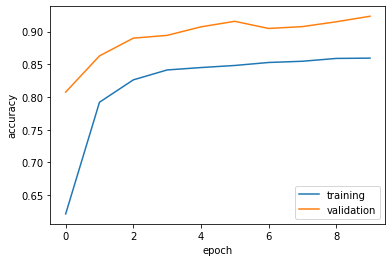

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()